# AN2DL - Homework 1

## 1 - Libraries and Dataset Import


In [ ]:
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import cv2
import os

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async" # Improve memory management and GPU utilization during model training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress most logs

import tensorflow as tf
import keras as tfk
from keras import layers as tfkl
from keras_cv import layers as kcvl
from keras import mixed_precision # To enable mixed precision training

tf.config.optimizer.set_jit(True)  # Enable XLA

print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(f"TensorFlow version {tf.__version__}")

np.random.seed(42)
tf.random.set_seed(42)

/home/teo/Desktop/LabANN/venvANNUbu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
I0000 00:00:1732222544.842358   29588 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732222544.885240   29588 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732222544.888915   29588 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but the

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version 2.17.0


In [2]:
data = np.load('training_set.npz') # Load the training set

X = data['images'] # Load the images
y = data['labels'] # Load the labels
print(X.shape, y.shape)

(13759, 96, 96, 3) (13759, 1)


## 2 - Checking for missing, duplicate values and class distribution

In [3]:
missing_targets = np.isnan(y.flatten()).any()

if not missing_targets :
    print("There are no missing or NaN values in the target vector.")

There are no missing or NaN values in the target vector.


In [4]:
# Duplicates count and removal
reshaped_X = X.reshape(X.shape[0], -1) # Reshape each image to a 1D vector and stack them for comparison

unique_X, unique_indices = np.unique(reshaped_X, axis=0, return_index=True) # Find unique images and their indices

# Select unique images and labels
X_unique = X[unique_indices]
y_unique = y[unique_indices]

print(f'Labels reduced from {len(y)} to {len(y_unique)}')

X = X_unique
y = y_unique

Labels reduced from 13759 to 11953


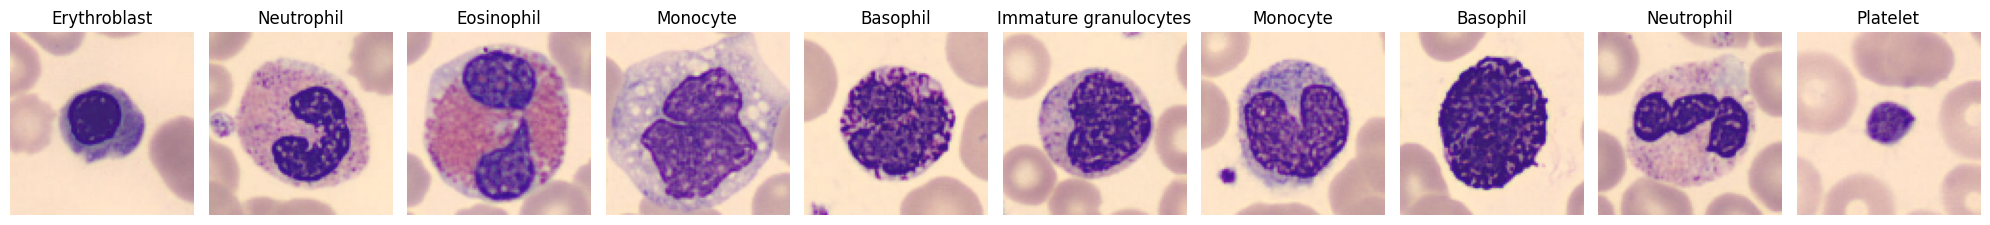

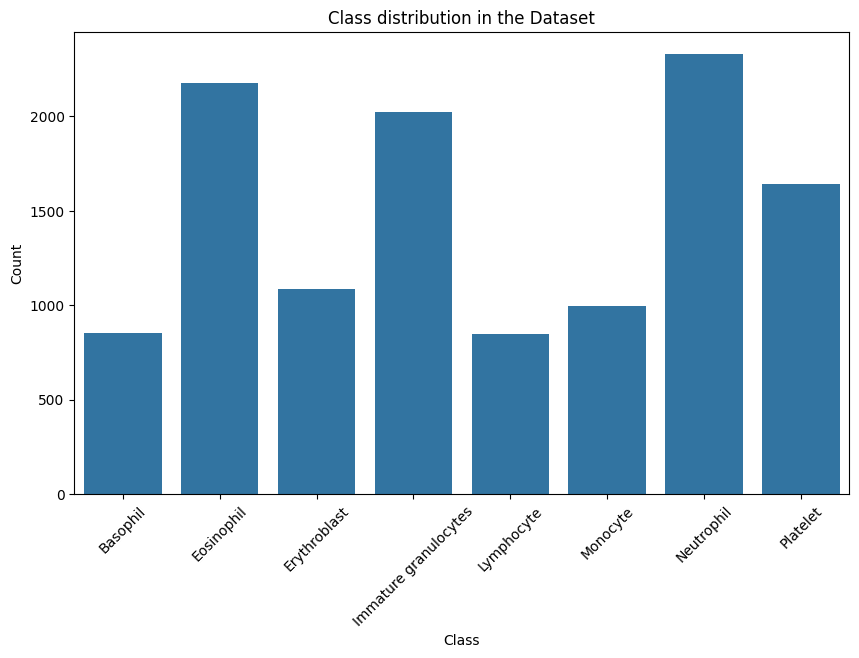

In [5]:
# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[y[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

labels_list, counts = np.unique(y.flatten(), return_counts=True)
classes = [labels[label] for label in labels_list]
df = pd.DataFrame({'Class': classes, 'Count': counts})

# Plot the barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=counts)
plt.title('Class distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Adjust rotation for readability if needed
plt.show()

## 3 - Split dataset into Train, Test and Validation sets while maintaining the distribution

In [ ]:
# Split data into training, test and validation sets, maintaining class distribution with stratification
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

Training Data Shape: (8605, 96, 96, 3)
Training Label Shape: (8605, 1)
Test Data Shape: (2391, 96, 96, 3)
Test Label Shape: (2391, 1)
Validation Data Shape: (957, 96, 96, 3)
Validation Label Shape: (957, 1)


## 4 - Image Augmentation

I0000 00:00:1732222554.587678   29588 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732222554.596630   29588 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732222554.599953   29588 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732222554.717894   29588 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

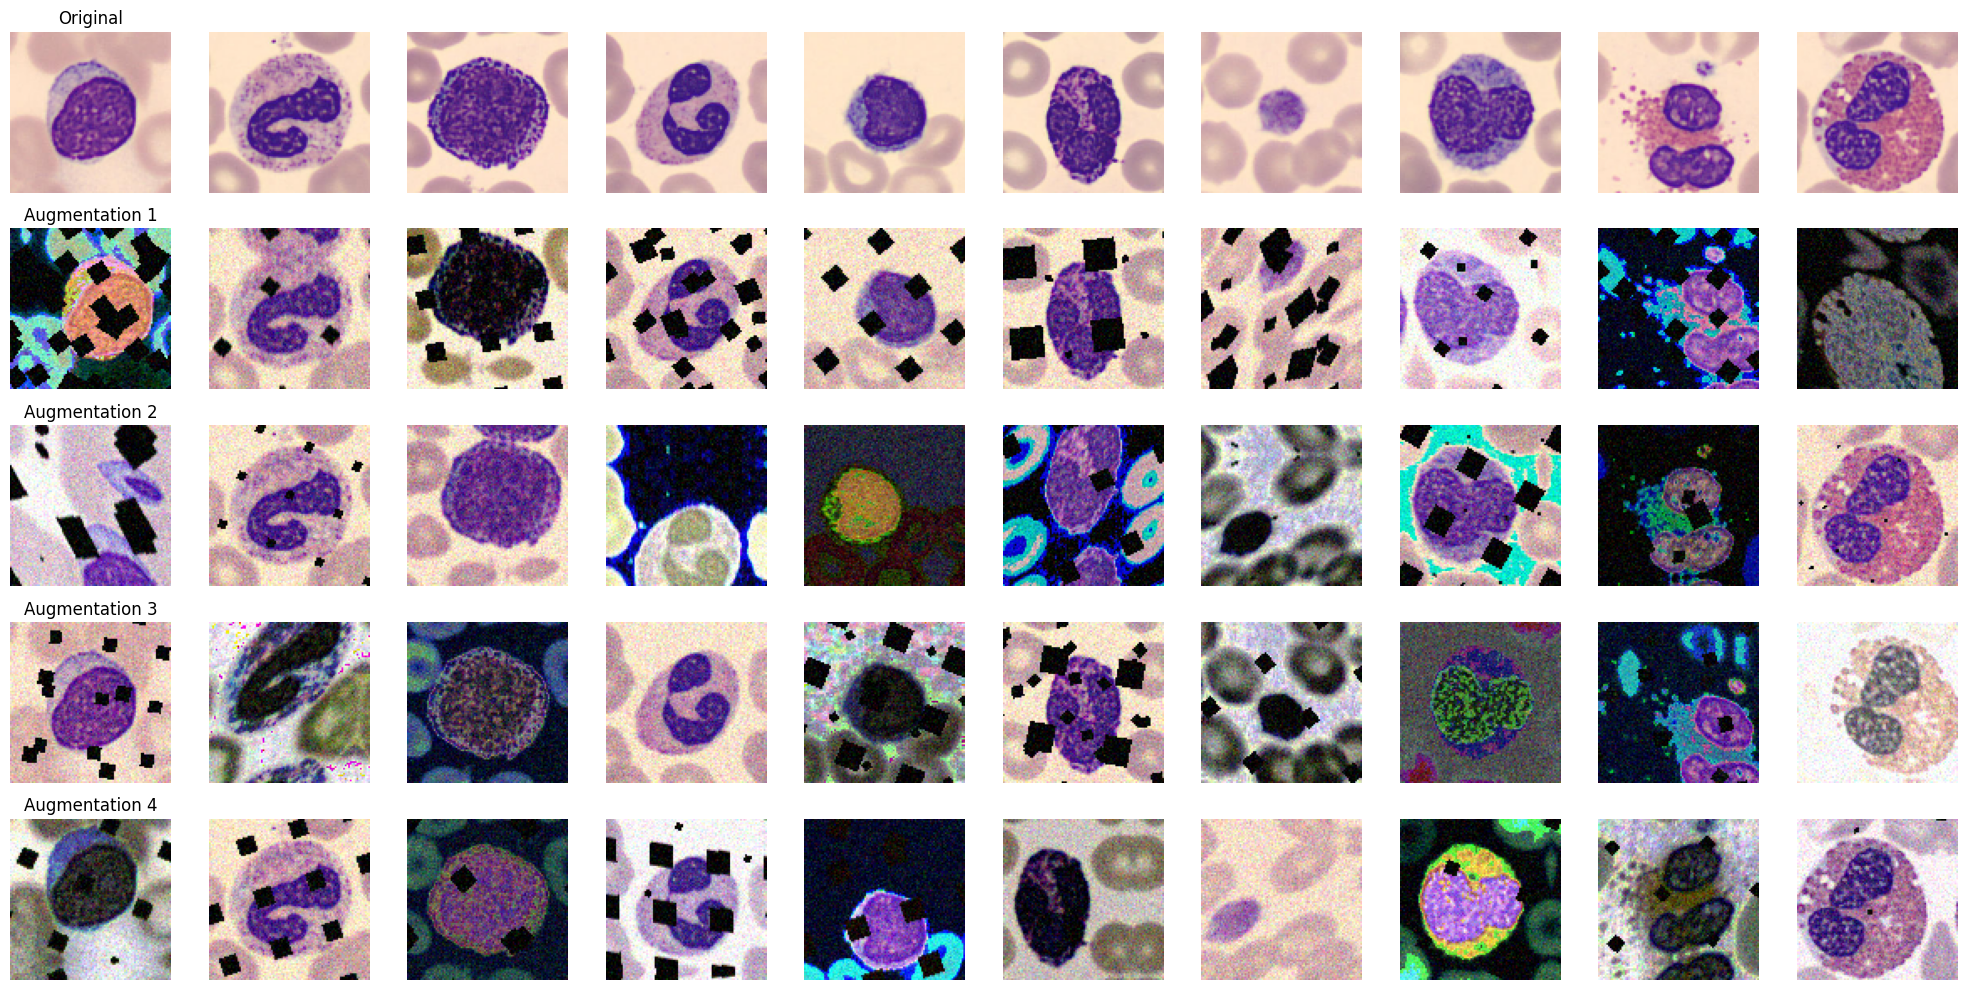

In [ ]:
from preprocessing import plot_augmented_images, create_train_dataset, create_val_dataset # Importing custom augmentation file
batch_size = 32 # Chosen to balance efficient GPU utilization, stable gradient updates, and reasonable training times
target_size = (96, 96)

# Plot augmented images for visualization, from a set of 10 samples
plot_augmented_images(X_train, y_train, num_images=10)

# Create datasets for training and validation
train_dataset = create_train_dataset(X_train, y_train, batch_size, target_size)
val_dataset = create_val_dataset(X_val, y_val, batch_size, target_size)

# 5. Training

In [ ]:
# Enabling mixed precision after augmentation, for its incompatibility with RandAugment and the Tensorflow version used
mixed_precision.set_global_policy('mixed_float16')

def build_model(input_shape, output_shape, learning_rate):
    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(inputs)
    x = tfkl.Activation('relu', name='act1')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

    x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dense(units=output_shape, name='dense')(x)

    outputs = tfkl.Activation('softmax', dtype='float32', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='basic_model')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

In [ ]:
for batch_images, batch_labels in train_dataset.take(1): # Defining input and output shapes, taken from an element in train_dataset
    print("Train batch images shape:", batch_images.shape)
    print("Train batch labels shape:", batch_labels.shape)
    input_shape = batch_images.shape[1:]
    output_shape = batch_labels.shape[1]
    print("Input Shape:", input_shape)
    print("Output Shape:", output_shape)

initial_learning_rate = 1e-4 # Selected to provide a stable starting point for optimization, balancing convergence speed

model = build_model(input_shape, output_shape, initial_learning_rate)
model.summary()

Train batch images shape: (32, 96, 96, 3)
Train batch labels shape: (32, 8)
Input Shape: (96, 96, 3)
Output Shape: 8


Model: "basic_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act1 (Activation)               │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp1 (MaxPooling2D)              │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act2 (Activation)               │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp2 (MaxPooling2D)              │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       294,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,312 (1.20 MB)

 Trainable params: 314,312 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 30 # Setting a limited number of epochs for the first basic model

# Creating an EarlyStopping callback, measured on validation loss
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Seting up the ReduceLROnPlateau callback
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce the learning rate by half
    patience=4,          # Wait for 4 with no improvement before reducing
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print updates to the console
)

In [ ]:
start_time = time.time() # Measure training time

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
).history

print("--- %s seconds ---" % (time.time() - start_time))

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'FinalSubmissions/basic_model.keras'
print('Saving to', model_filename)
model.save(model_filename)

Epoch 1/30


I0000 00:00:1732222582.198812   29970 service.cc:146] XLA service 0x5b9e0418fb40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732222582.198853   29970 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6


 31/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1699 - loss: 2.0802

I0000 00:00:1732222585.925459   29970 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


269/269 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.2601 - loss: 1.9270 - val_accuracy: 0.6364 - val_loss: 1.2632 - learning_rate: 1.0000e-04
Epoch 2/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.3990 - loss: 1.6620 - val_accuracy: 0.7043 - val_loss: 1.0210 - learning_rate: 1.0000e-04
Epoch 3/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.4475 - loss: 1.5582 - val_accuracy: 0.7565 - val_loss: 0.8788 - learning_rate: 1.0000e-04
Epoch 4/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.4846 - loss: 1.4830 - val_accuracy: 0.7649 - val_loss: 0.7823 - learning_rate: 1.0000e-04
Epoch 5/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.5023 - loss: 1.4442 - val_accuracy: 0.7774 - val_loss: 0.6896 - learning_rate: 1.0000e-04
Epoch 6/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.5159 - loss: 1.3826 - val_accuracy: 0.8109 - val_loss: 0.6201 - learning_rate: 1.0000e-04
Epoch 7/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accurac

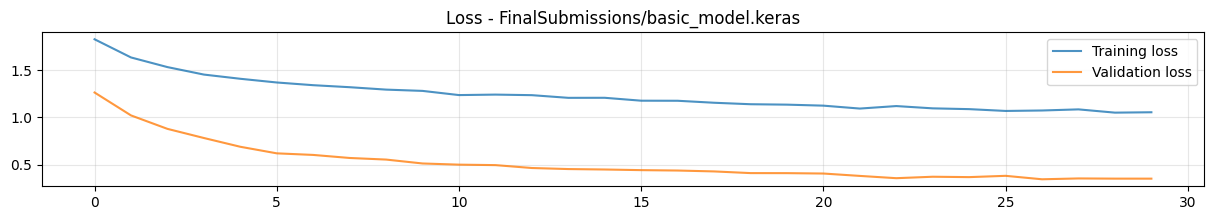

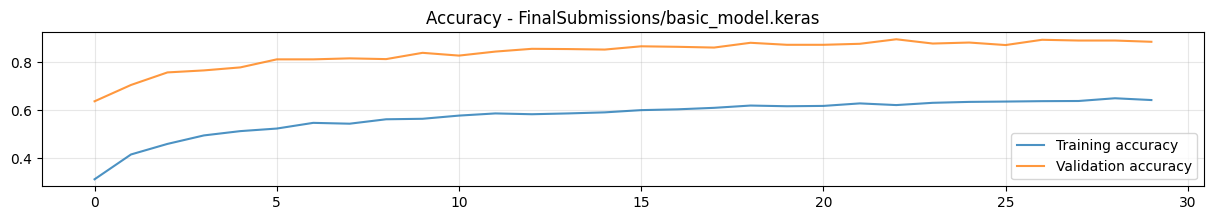

In [12]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title(f'Loss - {model_filename}')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title(f'Accuracy - {model_filename}')
plt.legend()
plt.grid(alpha=.3)
plt.show()


# 6. Evaluating the model

(2391, 96, 96, 3) (2391, 8)
Predictions Shape: (2391, 8)
Accuracy score over the test set: 0.89
Precision score over the test set: 0.8989
Recall score over the test set: 0.89
F1 score over the test set: 0.8884


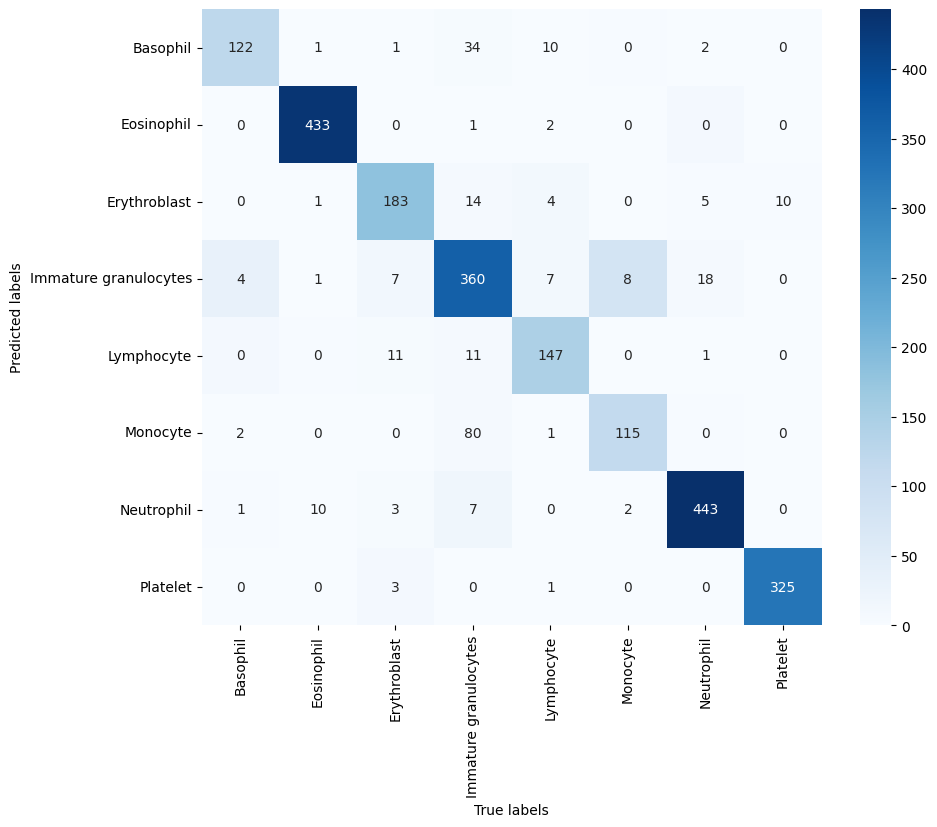

In [13]:
model = tfk.models.load_model(model_filename)

# Apply normalization and resizing to the test data directly, as done in the model.py submission file
X_normalized = (X_test / 127.5).astype('float32') - 1
X_resized = np.array([cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC) for img in X_normalized])
print(X_resized.shape, y_test.shape)

# Predict labels for the entire test set
predictions = model.predict(X_resized, verbose=0)

print("Predictions Shape:", predictions.shape)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()